In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [5]:
import pandas as pd
from pandas_datareader import data
from pylab import mpl, plt
import numpy as np
import plotly.express as px
import math 
import pandas_datareader.data as web
import scipy.stats as scs
import scipy.optimize as sco

In [6]:
import yfinance as yf
yf.pdr_override()

In [7]:
tickers=['PETR4.SA', 'VALE3.SA', 'BBAS3.SA', '^BVSP', 'TOTS3.SA']
df = web.get_data_yahoo(tickers, start='2016-01-01', end='2021-01-01')

precos=df['Adj Close'] # preços ajustados

rotulo = ['PETR', 'VALE', 'BBAS', '^BVSP', 'TOTS']
precos.columns=rotulo 
precos.head()
# precos.tail()

[*********************100%***********************]  5 of 5 completed


,PETR,VALE,BBAS,^BVSP,TOTS
Date,,,,,
2016-01-04,9.893964,3.027318,9.311222,8.419854,42141.0
2016-01-05,9.928702,2.943592,9.265714,8.307057,42419.0
2016-01-06,9.928702,2.820208,9.496292,7.696635,41773.0
2016-01-07,9.692472,2.758515,9.247508,7.238818,40695.0
2016-01-08,9.692472,2.762923,9.268746,6.993322,40612.0


In [ ]:
## ADICIONAR Á PLANILHA EXCEL

# precos.to_excel('precos.xlsx', enconding ='utf-8', index=True)

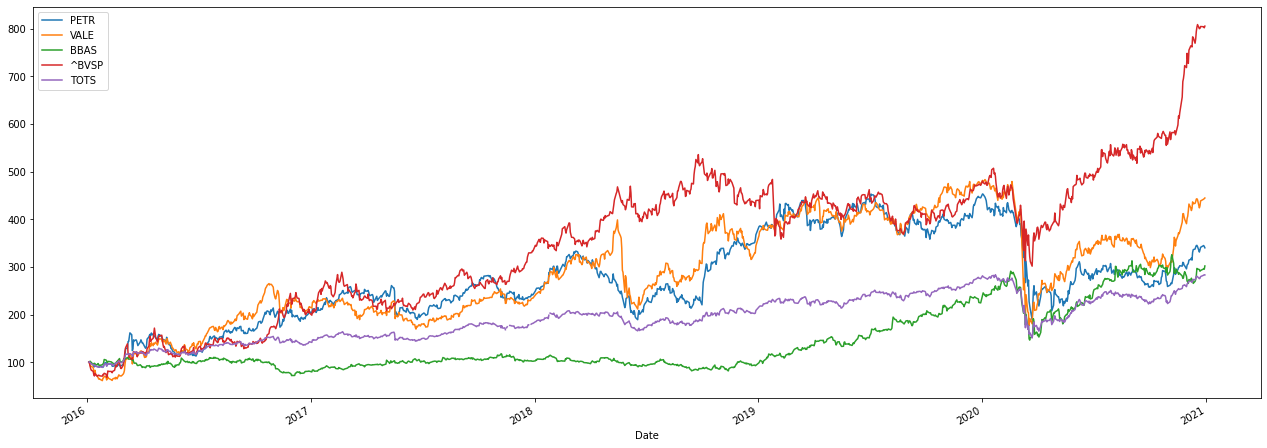

In [8]:
## Plotar gráficos do Precos de base 100

(precos/precos.iloc[0]*100).plot(figsize=(22,8))

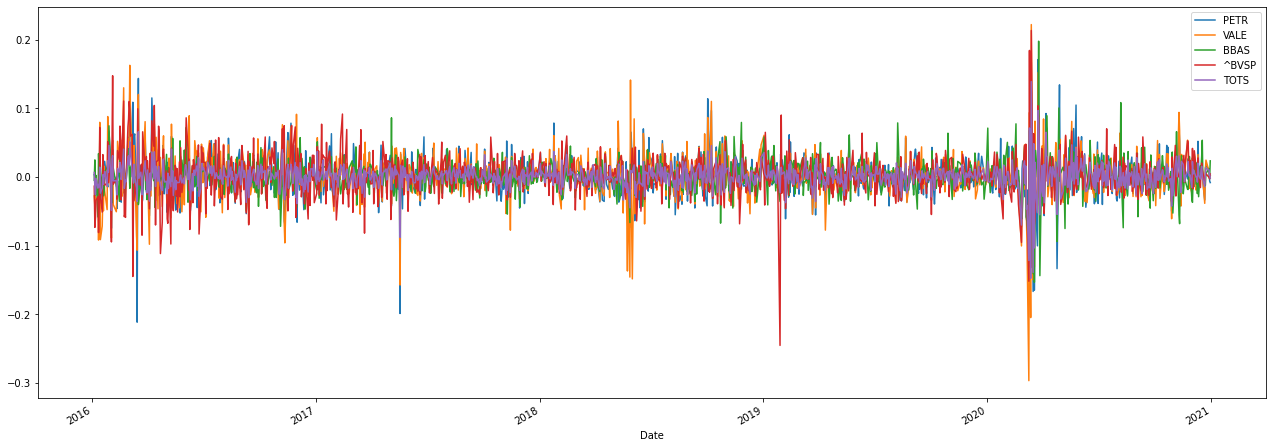

In [9]:
## Estimar os retornos diários

retornos=precos.pct_change()
retornos=retornos.dropna()

## Plotar o gráfico dos retornos
retornos.plot(figsize=(22,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f171d7910>,
      dtype=object)

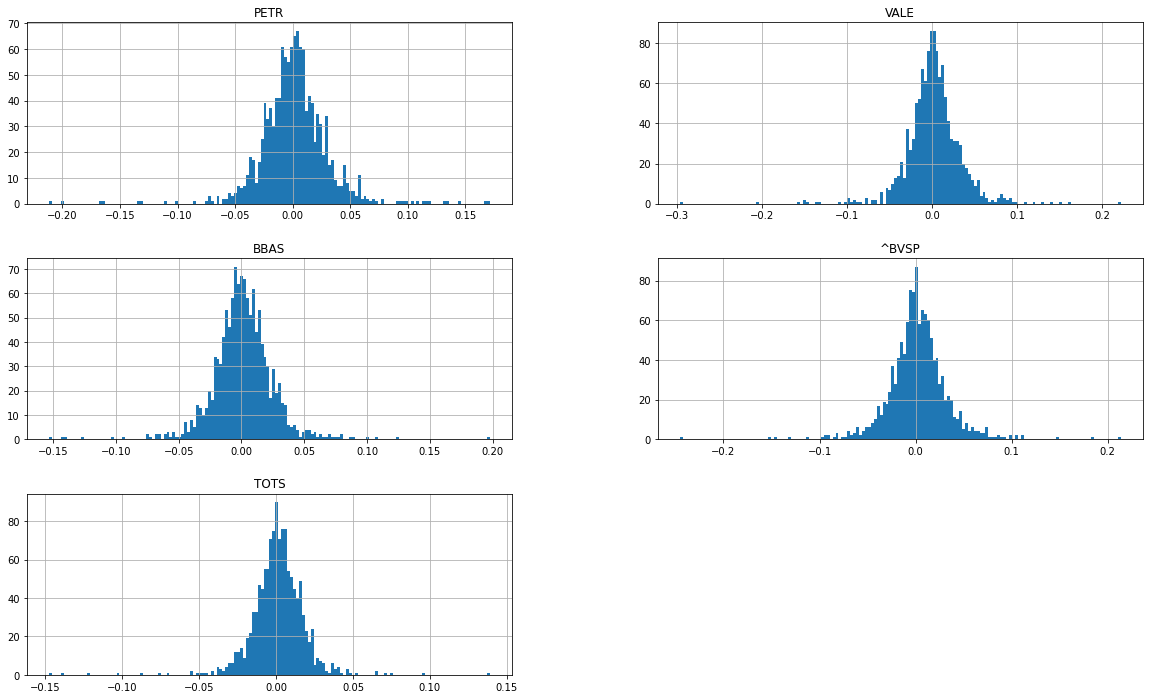

In [10]:
## Plotar histogramas

retornos.hist(bins=150,figsize=(20,12))

In [11]:
## Estimar a Assimetria e retornos max, min e mean
# retornos.mean()
desvios=retornos-retornos.mean()
sigma=retornos.std(ddof=0)
S=((desvios**3)/(sigma**3)).mean()
S

PETR    -0.216646
VALE    -0.620294
BBAS     0.017875
^BVSP   -0.092394
TOTS    -0.915520
dtype: float64

In [12]:
scs.skew(retornos)

array([-0.21664605, -0.62029446,  0.0178753 , -0.09239439, -0.9155204 ])

In [13]:
## Estatística Descritiva
stat=scs.describe(retornos)
Coluna=['PETR', 'VALE', 'BBAS', '^BVSP', 'TOTS']
Linhas=['Minimo', 'Máximo', 'Média', 'Variância', 'Desvio Padrão', 'Assimetria', 'Curtose']
stat
Minimo=scs.describe(retornos)[1] 
stat[1][0] 
minimo=stat[1][0]
maximo=stat[1][1]
media=stat[2]
variancia = stat [3]
desvio_padrao=variancia**0.5
assimetria = stat [4]
curtose = stat [5]
estat_desc = [minimo, maximo, media, variancia, desvio_padrao, assimetria, curtose]
# estat_desc
df = pd.DataFrame(data=estat_desc, index=Linhas, columns=Coluna)
df

,PETR,VALE,BBAS,^BVSP,TOTS
Minimo,-0.211712,-0.296978,-0.153436,-0.245592,-0.147797
Máximo,0.171260,0.222222,0.197996,0.213578,0.139082
Média,0.001426,0.001750,0.001186,0.002144,0.000991
Variância,0.000877,0.001078,0.000594,0.000927,0.000305
Desvio Padrão,0.029614,0.032840,0.024364,0.030451,0.017477
Assimetria,-0.216646,-0.620294,0.017875,-0.092394,-0.915520
Curtose,8.734682,11.093641,8.440374,8.282810,14.986008


In [14]:
## Estimar os retornos esperados
t=rotulo
var=retornos.var()
e_r=retornos.mean()
vol=var**0.5


# Estimar a matriz de covariância
matriz_cov=retornos.cov()
matriz_cov


,PETR,VALE,BBAS,^BVSP,TOTS
PETR,0.000877,0.000672,0.000263,0.000349,0.000427
VALE,0.000672,0.001078,0.000260,0.000508,0.000464
BBAS,0.000263,0.000260,0.000594,0.000185,0.000211
^BVSP,0.000349,0.000508,0.000185,0.000927,0.000327
TOTS,0.000427,0.000464,0.000211,0.000327,0.000305


In [15]:
## carteira de cois 2 ativos de forma fácil

# Retornos esperados
e_r_Vale = e_r['VALE']
e_r_Tots = e_r['TOTS']


# Volatilidade e Covariância
vol_Vale = vol['VALE']
vol_Tots = vol['TOTS']
cov_Vale_Tots = retornos ['VALE'].cov(retornos['TOTS'])

# Pesos dos ativos (Quanto eu vou investir em cada ativo)

wa = 0.1
wb = 1 - wa

# Retorno e Risco da Carteira

ret_port = wa*e_r_Vale + wb*e_r_Tots
vol_port = (wa**2*vol_Vale**2+wb**2*vol_Tots**2+2*wa*wb*cov_Vale_Tots)**0.5

# vol_port

port = pd.DataFrame(data=[wa,wb,ret_port,vol_port],index=['Petr (%)','Jhsf (%)','Retorno','Risco'], columns=['Carteira com 2 ativos'])



In [16]:
## Curva de Risco e Retorno (Markowitz) para uma carteira com dois Ativos 

curva_risco=[]
curva_ret=[]
l = 100

for w in np.linspace(1,0,l):
  risc_port = (wa**2*vol_Tots**2+(1-w)**2*vol_Vale**2+2*w*(1-w)*cov_Vale_Tots)**0.5
  curva_risco.append(risc_port)
  ret_port=w*e_r_Tots + (1-w)*e_r_Vale
  curva_ret.append(ret_port)

d={'Peso Vale': np.linspace(1,0,l), 'Peso Tots': np.linspace(0,1,l), 'Risco':curva_risco, 'Retorno':curva_ret}
carteira=pd.DataFrame(d)





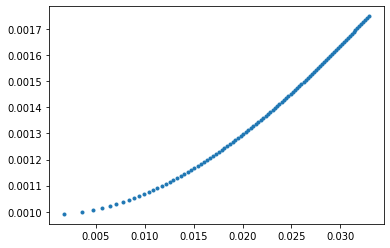

In [17]:
## Plotar Gráfico do Risco e Retorno

plt.plot(curva_risco, curva_ret, '.')

Text(0, 0.5, 'Retorno')

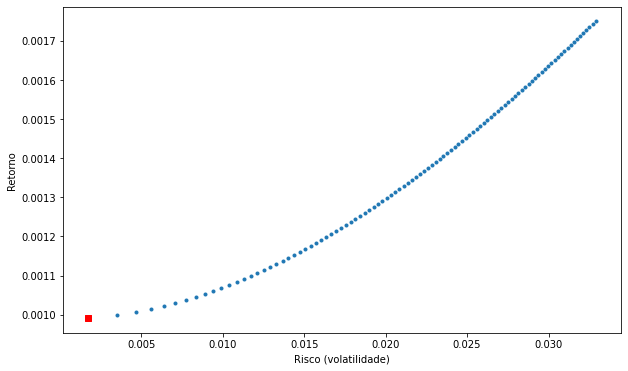

In [18]:
min_vol = carteira[carteira['Risco']==carteira['Risco'].min()]

plt.figure(figsize=(10,6))
plt.scatter(carteira['Risco'], carteira['Retorno'], marker='.')
plt.scatter(min_vol['Risco'], min_vol['Retorno'], marker=',', color='r')
plt.xlabel('Risco (volatilidade)')
plt.ylabel('Retorno')

In [19]:
## Estimar o Indice Sharpe

rf = (0.08+1)**(1/252)-1 # Taxa livre de risco convertida ao dia útil
Sharpe = (carteira['Retorno']-rf)/carteira['Risco']

d={'Peso Vale': np.linspace(1,0,l), 'Peso Tots': np.linspace(0,1,l), 'Risco':curva_risco, 'Retorno':curva_ret, 'Sharpe': Sharpe}
carteira=pd.DataFrame(d)
carteira

,Peso Vale,Peso Tots,Risco,Retorno,Sharpe
0,1.000000,0.000000,0.001748,0.000991,0.392493
1,0.989899,0.010101,0.003529,0.000999,0.196570
2,0.979798,0.020202,0.004677,0.001007,0.149929
3,0.969697,0.030303,0.005598,0.001014,0.126645
4,0.959596,0.040404,0.006389,0.001022,0.112155
...,...,...,...,...,...
95,0.040404,0.959596,0.032127,0.001719,0.044004
96,0.030303,0.969697,0.032318,0.001727,0.043982
97,0.020202,0.979798,0.032508,0.001734,0.043960
98,0.010101,0.989899,0.032697,0.001742,0.043939


Text(0, 0.5, 'Retorno')

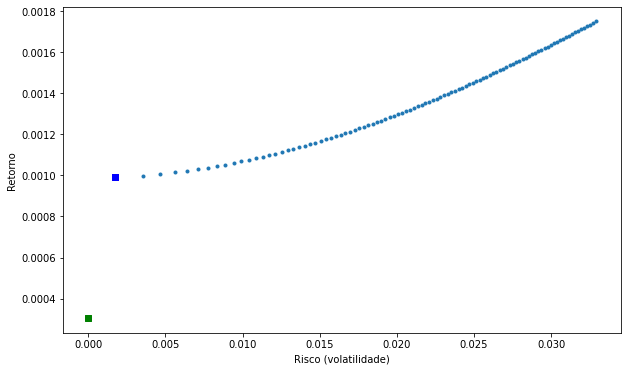

In [20]:
## Carteira com maior Sharpe

max_s=carteira[carteira['Sharpe']==carteira['Sharpe'].max()]

plt.figure(figsize=(10,6))
plt.scatter(carteira['Risco'], carteira['Retorno'], marker='.')
plt.scatter(min_vol['Risco'], min_vol['Retorno'], marker=',', color='r')
plt.scatter(max_s['Risco'], max_s['Retorno'], marker=',', color='b')
plt.scatter(0, rf, marker=',', color='g')
plt.xlabel('Risco (volatilidade)')
plt.ylabel('Retorno')

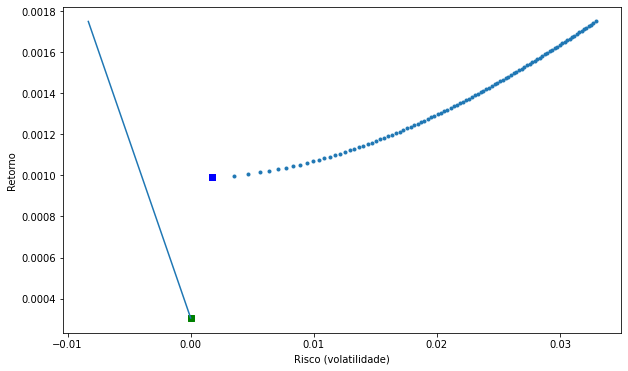

In [21]:
## Calcular a Linha de alocação de capital

cal_x=[]
cal_y=[]
Utilidade=[]
a = 20 # nível de aversão ao risco 

for er in np.linspace(rf,max(carteira['Retorno']), 20):
  sd=(er-rf)/(max_s['Retorno']-rf/max_s['Risco']) # equação de uma reta
  u = er-0.5*a*(sd**2)
  cal_x.append(sd)
  cal_y.append(er)
  Utilidade.append(u) 

data2={'Utilidade':Utilidade,'Retorno da reta': cal_y,'Risco da Reta': cal_x}
cal=pd.DataFrame(data2)
#cal

## Plotar gráfico

plt.figure(figsize=(10,6))
plt.scatter(carteira['Risco'], carteira['Retorno'], marker='.')
plt.scatter(min_vol['Risco'], min_vol['Retorno'], marker=',', color='r')
plt.scatter(max_s['Risco'], max_s['Retorno'], marker=',', color='b')
plt.scatter(0, rf, marker=',', color='g')
plt.xlabel('Risco (volatilidade)')
plt.ylabel('Retorno')
plt.plot(cal_x, cal_y)

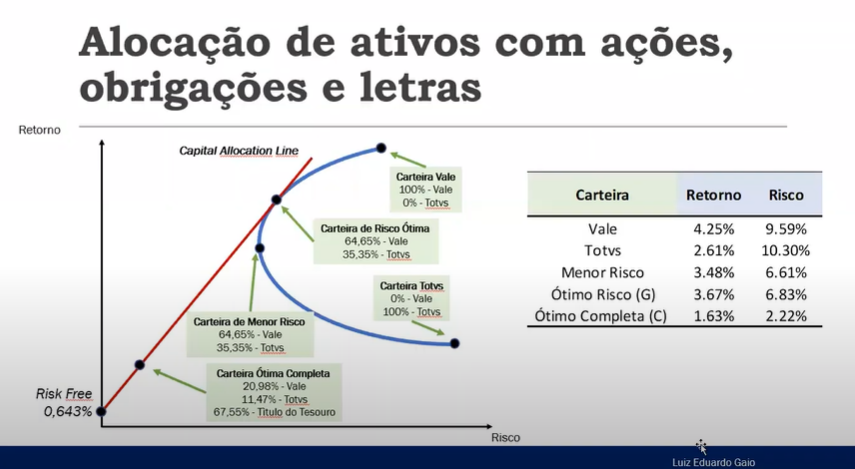

In [22]:
## Estimar a carteira ótima completa 

wp=(max_s['Retorno']-rf)/(a*max_s['Risco']**2)
#wp

ret_oc = wp*max_s['Retorno']+(1-wp)*rf
vol_oc=wp*max_s['Risco']
o = {'Peso Risco': wp, 'Peso Rf':(1-wp), 'Risco':vol_oc, 'Retorno':ret_oc}
otima = pd.DataFrame(o)
otima

,Peso Risco,Peso Rf,Risco,Retorno
0,11.228963,-10.228963,0.019625,0.008008


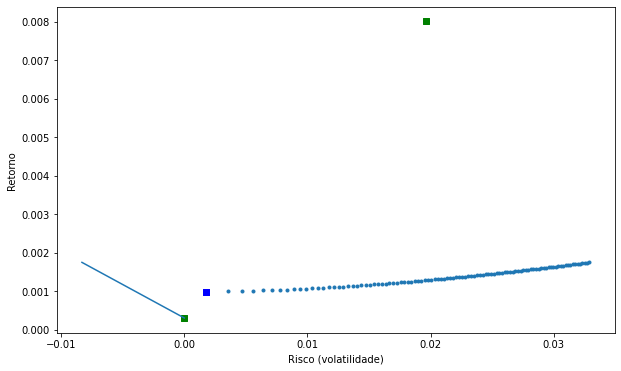

In [23]:
# Plotar o gráfico

plt.figure(figsize=(10,6))
plt.scatter(carteira['Risco'], carteira['Retorno'], marker='.')
plt.scatter(min_vol['Risco'], min_vol['Retorno'], marker=',', color='r')
plt.scatter(max_s['Risco'], max_s['Retorno'], marker=',', color='b')
plt.scatter(0, rf, marker=',', color='g')
plt.scatter(otima['Risco'], otima['Retorno'], marker=',', color='g')
plt.xlabel('Risco (volatilidade)')
plt.ylabel('Retorno')
plt.plot(cal_x, cal_y)

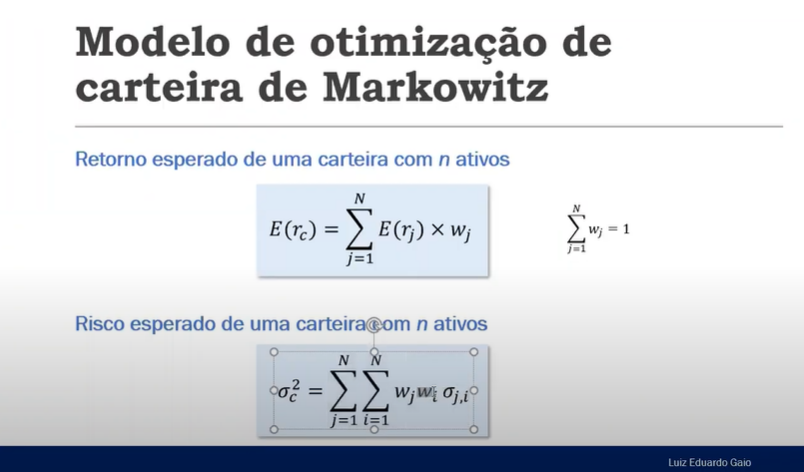

In [24]:
#  Carteira com mais ativos
p_ret=[]
p_vol=[]
p_pesos=[]

noa=len(retornos.columns)
nop = 1000

for portfolios in range(nop):
  pesos=np.random.random(noa)
  pesos=pesos/np.sum(pesos)
  p_pesos.append(pesos)
  returns=np.dot(pesos,e_r)
  p_ret.append(returns)
  var=matriz_cov.mul(pesos, axis=0).mul(pesos, axis=1).sum().sum() # axis = 0 é a Vale e axis = 1 Tots
  dp = np.sqrt(var) # desvio padrão igual a raiz da variância
  p_vol.append(dp)


# p_ret # 100 retornos de portfólio 
# p_pesos # pesos de cada ativo aleatório

p_ret = np.array(p_ret)
p_vol=np.array(p_vol)
# montar um dataframe
dados={'Retorno': p_ret, 'Risco': p_vol}
portfolios = pd.DataFrame(dados)
portfolios



,Retorno,Risco
0,0.001529,0.021019
1,0.001391,0.020626
2,0.001622,0.022860
3,0.001632,0.023692
4,0.001514,0.020893
...,...,...
995,0.001339,0.019846
996,0.001351,0.021772
997,0.001391,0.022710
998,0.001769,0.022952


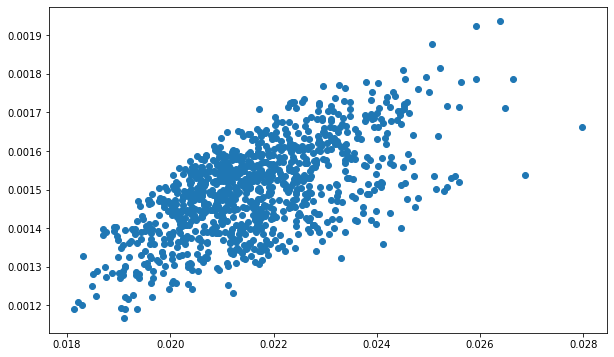

In [25]:
## Plotar gráfico de dispersão
# O gráfico de dispersão é usado 
plt.figure(figsize=(10,6))
plt.scatter(portfolios['Risco'], portfolios['Retorno'])
# px.scatter(portfolios['Risco'], portfolios['Retorno'])

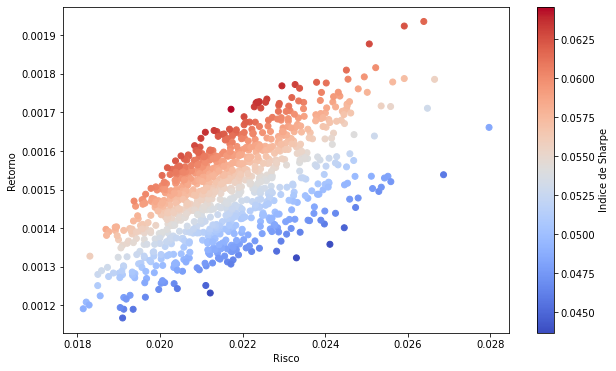

In [26]:
## Plotar gráfico com Sharpe 

plt.figure(figsize=(10,6))
plt.scatter(p_vol, p_ret, c=((p_ret-rf)/p_vol), marker='o', cmap='coolwarm')
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Indice de Sharpe')


In [27]:
## Encontrar a carteira de menor risco

min_risk=portfolios[portfolios['Risco']==portfolios['Risco'].min()]
p_pesos[370]
df={'Petr':p_pesos[370][0], 'Vale':p_pesos[370][1], 'Bbas':p_pesos[370][2], 'Tots':p_pesos[370][4], 'Retorno':min_risk['Retorno'], 'Risco':min_risk['Risco']}
pd.DataFrame(df)


,Petr,Vale,Bbas,Tots,Retorno,Risco
569,0.569668,0.187752,0.005147,0.129907,0.001191,0.018142


In [28]:
## FUNÇÕES PARA ESTIMAR O RISCO E RETORNO DE UM PORTFÓLIO 

def port_ret (pesos): 
  return np.sum(e_r*pesos)  

def port_vol(pesos):
  return math.sqrt(np.dot(pesos.T, np.dot(matriz_cov, pesos)))  # Matriz transposta 


In [29]:
teste=(0.1,0.1,0.5,0.1, 0.1)
port_ret(teste)

0.0012240727128872556

In [30]:
## Carteira de menor risco por otimização

# tem que ter uma restrição 
restri = ({'type': 'eq', 'fun':lambda x: np.sum(x)-1})
bnds=tuple((0,1) for x in range(noa))
# bnds
pesos_i=np.array(noa*[1/noa,])
# pesos_i

# otimização da carteira
otim_v=sco.minimize(port_vol, pesos_i, method='SLSQP', bounds=bnds, constraints=restri)
# otim_v

# Pesos otimizados
otim_v['x'].round(3)

# Retorno da carteira de menor risco global
port_ret(otim_v['x'])

# Risco da carteira de menor risco global
port_vol(otim_v['x'])


0.01693483366213522

In [31]:
## CARTEIRA DE MÁXIMO SHARPE 

# Usar dois métodos 

SR = (p_ret-rf)/p_vol
SR.max()

0.06457689203079554

In [32]:
## Estimar carteira de sharpe máximo (ótimo)

# Função do Sharpe

def min_func_sharpe(pesos):
  return -(port_ret(pesos)-rf)/port_vol(pesos)

# otimização do Sharpe
otim_s=sco.minimize(min_func_sharpe, pesos_i, method='SLSQP', bounds=bnds, constraints=restri)

# Pesos otimizados (menor sharpe)

otim_s['x'].round(3)
otim_s

# Retorno da Carteira
port_ret(otim_s['x'])


# Risco da carteira
port_vol(otim_s['x'])

# Máximo sharpe
(port_ret(otim_s['x'])-rf)/port_vol(otim_s['x'])

0.06516559013668556

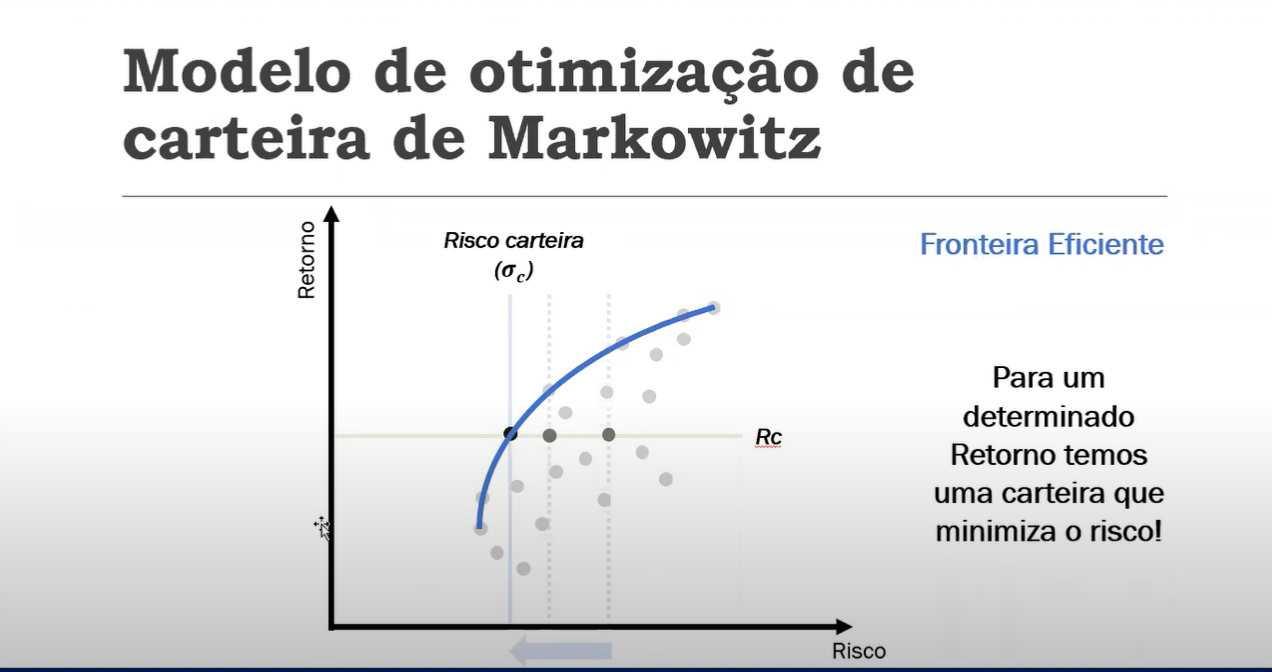

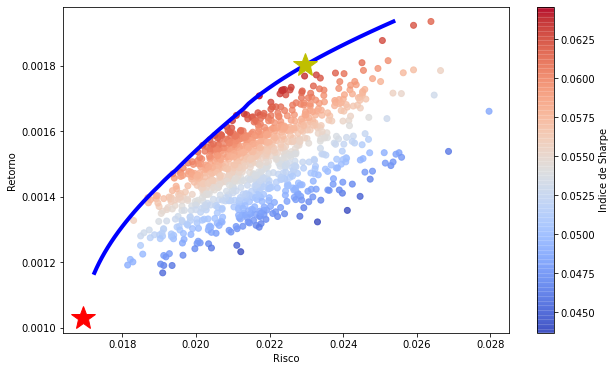

In [33]:
## ESTIMAÇÃO DA FRONTEIRA DE MARKOWITZ

cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, {'type':'eq','fun':lambda x: np.sum(x)-1})
bnds=tuple((0,1) for x in pesos)
trets = np.linspace(p_ret.min(), p_ret.max(), 50)
#trets

tvols=[]
for tret in trets:
  res = sco.minimize(port_vol,pesos_i,method='SLSQP',bounds=bnds,constraints=cons) # função de minimizaçã
  tvols.append(res['fun'])

tvols = np.array(tvols)
#t_vols

# Gráfico da fronteira eficiente

plt.figure(figsize=(10,6))
plt.scatter(p_vol, p_ret, c=(p_ret-rf)/p_vol, marker='o', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(otim_s['x']), port_ret(otim_s['x']), 'y*', markersize=25.0)
plt.plot(port_vol(otim_v['x']), port_ret(otim_v['x']),'r*', markersize=25.0)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Indice de Sharpe')

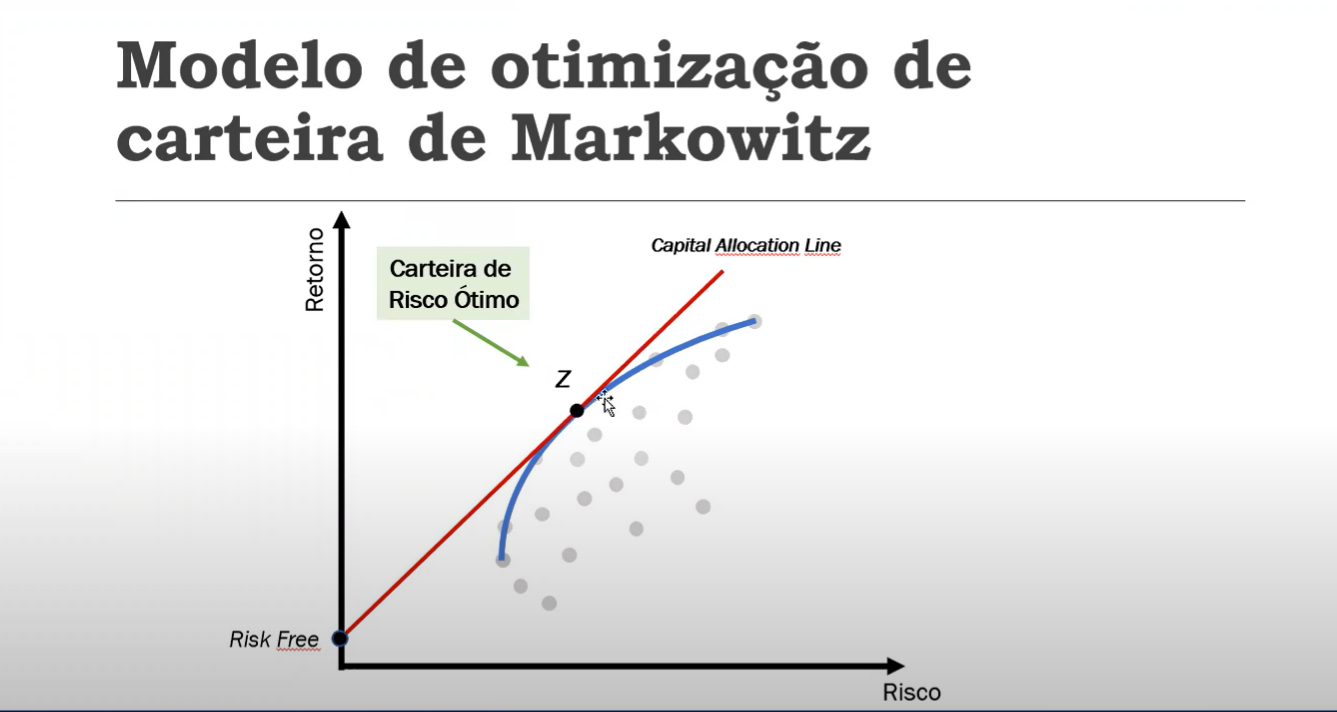

In [34]:
### LINHA DE ALOCAÇÃO DE CAPITAL

eixo_x=[]
eixo_y=[]
Utility=[]
a = 10 # Nível de aversão ao risco

for er in np.linspace(rf, max(trets), 20):
  sd = (er - rf)/((port_ret(otim_s['x'])-rf)/port_vol(otim_s['x']))
  u = er - 0.5*a*(sd**2)
  eixo_x.append(sd)
  eixo_y.append(er)
  Utility.append(u)

data3={'Utilidade': Utility,'Retorno':eixo_y,'Risco':eixo_x}
cal=pd.DataFrame(data3)
cal


,Utilidade,Retorno,Risco
0,0.000305,0.000305,0.000000
1,0.000383,0.000391,0.001316
2,0.000442,0.000477,0.002633
3,0.000485,0.000563,0.003949
4,0.000510,0.000649,0.005266
5,0.000518,0.000734,0.006582
6,0.000508,0.000820,0.007899
7,0.000481,0.000906,0.009215
8,0.000437,0.000992,0.010532
9,0.000376,0.001078,0.011848


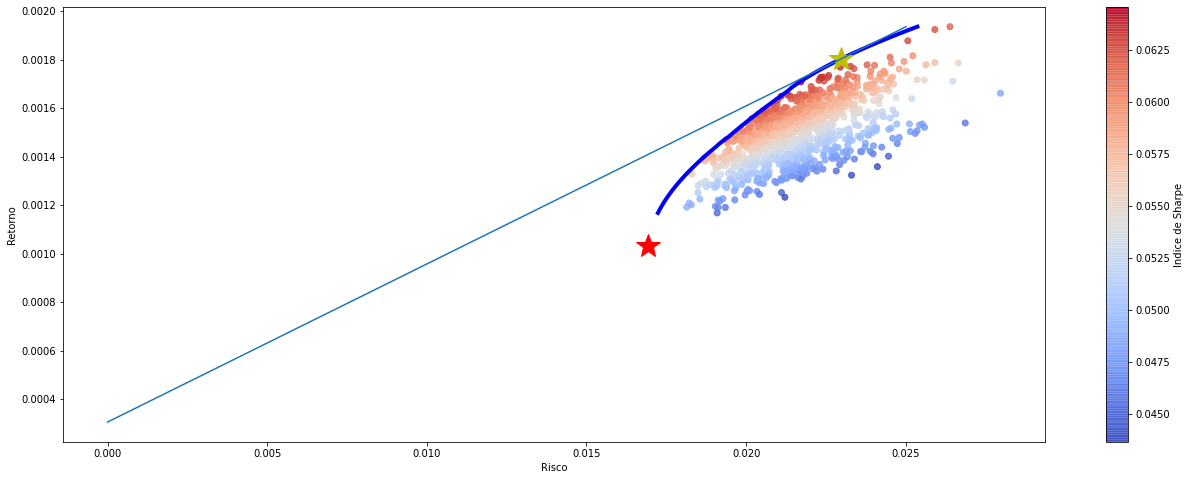

In [35]:
# Gráfico de Fronteira Eficiente de Markowitz

plt.figure(figsize=(22,8))
plt.scatter(p_vol, p_ret, c=(p_ret-rf)/p_vol, marker='o', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(otim_s['x']), port_ret(otim_s['x']), 'y*', markersize=25.0)
plt.plot(port_vol(otim_v['x']), port_ret(otim_v['x']),'r*', markersize=25.0)
plt.plot(eixo_x,eixo_y)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Indice de Sharpe')


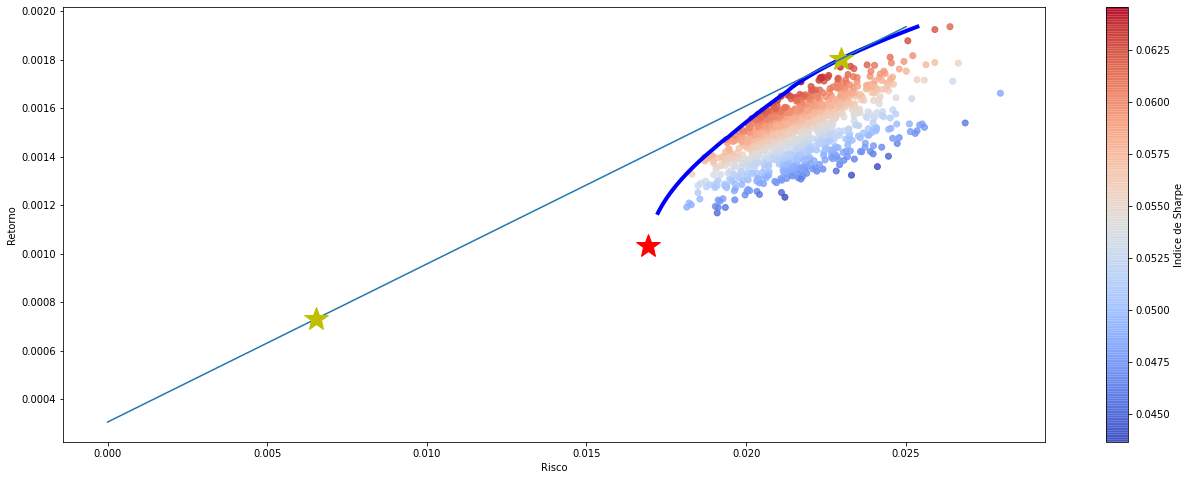

In [39]:
## CARTEIRA ÓTIMA COMPLETA 

wp = (port_ret(otim_s['x'])-rf)/(a*port_vol(otim_s['x'])**2)
#wp

r_oc = wp*port_ret (otim_s['x'])+(1-wp)*rf
v_oc = wp*port_vol(otim_s['x'])

# Gráfico da Fronteira eficiente com CAL (Carteira Ótima)

plt.figure(figsize=(22,8))
plt.scatter(p_vol, p_ret, c=(p_ret-rf)/p_vol, marker='o', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(otim_s['x']),port_ret(otim_s['x']),'y*', markersize=25.0)
plt.plot(port_vol(otim_v['x']),port_ret(otim_v['x']),'r*', markersize=25.0)
plt.plot(eixo_x,eixo_y)
plt.plot(v_oc, r_oc, 'y*', markersize=25.0)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Indice de Sharpe')
